# Imports

In [5]:
import pandas as pd
import numpy as np
import inspect
import statsmodels.api as sm
import statsmodels.formula.api as smf

from matplotlib import pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

# # Imports for Pycox

# # For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn_pandas import DataFrameMapper 
from sklearn.metrics import mean_squared_error, r2_score


import torch # For building the networks 
import torchtuples as tt # Some useful functions

# import pycox as pc
from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
np.random.seed(1234)
_ = torch.manual_seed(123)

In [6]:
from util import import_and_shape_data, run_pycox_on_group

interval_and_weather_merged = import_and_shape_data()

(298, 21)
(46, 21)


# First attempt at regression

INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
slope b1 is -0.0006776187411433997
intercept b0 is 0.5766594727875036


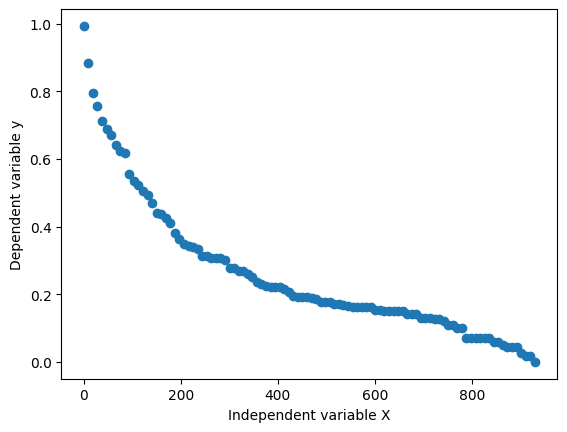

In [7]:
# Step 1: Select relevant columns
cols_input = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_insect']
interval_and_weather_merged_under_1000 = interval_and_weather_merged[(interval_and_weather_merged['interval'] <= 1000)]
df_interval_and_weather_merged_under_1000 = interval_and_weather_merged_under_1000[cols_input]
fit_model, base_model, x_test, df_test, x_mapper = run_pycox_on_group(df_interval_and_weather_merged_under_1000, 100)
surv = base_model.predict_surv_df(x_test)

# Predict the slope and coefficients for time segment
# TODO: decide if these items should become a function 
surv['mean'] = surv.mean(axis=1)
surv['sem'] = surv.sem(axis='columns')

def run_linear_regression(surv):
  x = surv.index.values
  y = surv['mean'].values
  n = np.size(x)

  x_mean = np.mean(x)
  y_mean = np.mean(y)
  x_mean,y_mean

  Sxy = np.sum(x*y)- n*x_mean*y_mean
  Sxx = np.sum(x*x)-n*x_mean*x_mean

  b1 = Sxy/Sxx
  b0 = y_mean-b1*x_mean
  print('slope b1 is', b1)
  print('intercept b0 is', b0)

  plt.scatter(x,y)
  plt.xlabel('Independent variable X')
  plt.ylabel('Dependent variable y')

run_linear_regression(surv)

In [32]:
# TODO make the lt(.5) a data point
def format_survival_data(surv, less_than_value):
    # Find index values where each column is less than 0.5
    less_than_half = surv.lt(less_than_value)

    # Get the first index where the condition is true for each column
    first_less_than_half = less_than_half.idxmax()

    # Print the index values
    # for column in first_less_than_half.index:
    #     print(f"Column {column}:")
    #     print(first_less_than_half[column])
    #     print()


    return np.array(first_less_than_half)

# surv.drop(['sem', 'mean'], inplace=True, axis=1)
# first_less_than_half_array = format_survival_data(surv, .5)

# Multiple Regression
def run_multiple_regression(df_test, surv):
  first_less_than_half_array = format_survival_data(surv, .1)
  x = df_test.drop(['status', 'interval'], axis=1)

  # Create the dependent variable
  y = first_less_than_half_array

  # Create the regression model
  model = LinearRegression()

  # Fit the model to the data
  model.fit(x, y)

  # Get the coefficients
  coefficients = pd.DataFrame(zip(x.columns, model.coef_))

  # Get the intercept
  intercept = model.intercept_

  # Print the results
  print('Coefficients:', coefficients)
  print('Intercept:', intercept)

# Run the regression with statsmodels
# model2 = ols(formula='interval ~ same_insect + temp + wspd + dwpt + coco', data=data)
# results = model2.fit()

# # Print the results from statsmodels
# print(results.summary())

# run_multiple_regression(df_test, first_less_than_half_array)

In [10]:
# Moving the cut-off of first 1000 seconds to after training pycox model
cols_input = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_insect']
interval_and_weather_merged = interval_and_weather_merged[cols_input]
fit_model, base_model, x_test, df_test, x_mapper = run_pycox_on_group(interval_and_weather_merged, 100)

df_test_under_1000 = df_test[(df_test['interval'] <= 1000)]
x_test_under_1000 = x_mapper.transform(df_test_under_1000).astype('float32')
surv = base_model.predict_surv_df(x_test_under_1000)

run_multiple_regression(df_test_under_1000, surv)


INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
Coefficients:              0          1
0         temp  20.856140
1         dwpt  -4.951015
2         wspd -22.164062
3         coco -52.851038
4  same_insect  -8.769314
Intercept: 421.58351263457735


# New functions based on updated guidance for regression

### TODO:
- Go back and figure out how to get smaller increments of time from base_model.predict_surv_df(x_test) call. Look at this https://github.com/havakv/pycox/issues/58
- Validate the output of get_slope_of_population_curve function

- Potentailly need to get the slope of the curve for each individual survival curve

In [33]:
def get_slope_of_survival_curve(surv, start_time, end_time):

  sliced_surv = surv.loc[(surv.index >= start_time) & (surv.index <= end_time)]
  
  x = sliced_surv.index.values
  y = sliced_surv.values
  n = np.size(x)
  print('inside get_slope', y)

  # Use Scikit to get slope
  x = x.reshape(-1,1)
  regression_model = LinearRegression()

  # Fit the data(train the model)
  regression_model.fit(x, y)

  return regression_model.coef_[0]

def get_slope_of_population_curve(surv, start_time, end_time):
  surv['mean'] = surv.mean(axis=1)
  surv['sem'] = surv.sem(axis='columns')

  sliced_surv = surv.loc[(surv.index >= start_time) & (surv.index <= end_time)]
  # print('sliced_surv', sliced_surv)


  
  x = sliced_surv.index.values
  y = sliced_surv['mean'].values
  n = np.size(x)

  # Use Scikit to get slope
  x = x.reshape(-1,1)
  regression_model = LinearRegression()

  # Fit the data(train the model)
  regression_model.fit(x, y)

  # Predict
  y_predicted = regression_model.predict(x)

  # model evaluation
  mse=mean_squared_error(y,y_predicted)

  rmse = np.sqrt(mean_squared_error(y, y_predicted))
  r2 = r2_score(y, y_predicted)

  # printing values
  # print('Slope:' ,regression_model.coef_)
  # print('Intercept:', regression_model.intercept_)
  # print('MSE:',mse)
  # print('Root mean squared error: ', rmse)
  # print('R2 score: ', r2)
  return regression_model.coef_[0]


get_slope_of_population_curve(surv, 50, 150)

-0.0027178079448314427

In [26]:
# first case first 50-150 seconds
start = 50
end = 150
fit_model, base_model, x_test, df_test, x_mapper = run_pycox_on_group(interval_and_weather_merged, 1000)

# Get general survival for all the data
surv_general = base_model.predict_surv_df(x_test)


# Get predicted survivals for all relevant data 
# Question how do I make sure I am just predicting the change from 50-100 just based on my y being the slope?
df_test_over_50 = df_test[(df_test['interval'] >= 50)]
x_test_over_50 = x_mapper.transform(df_test_over_50).astype('float32')
surv = base_model.predict_surv_df(x_test_over_50)

# Manually calculate the slope of the population survival curve for the time-segment
slope_of_population_curve = get_slope_of_population_curve(surv_general, start, end)

# run a regression with the data and from the test and the slope
slope_of_population_curve

INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah


-0.002393784048884691

In [36]:
np.full(df_test.shape[0], slope_of_population_curve)
df_test.shape

print(get_slope_of_survival_curve(surv.iloc[:, 5], start, end))

# Apply the function to every column in 'surv'
slope_values = surv.apply(lambda col: get_slope_of_survival_curve(col, start, end))
print(slope_values)
# Add the slope values as a new column to 'surv'
surv['slope_values'] = slope_values

# surv.iloc[:, 5]
surv

-9.937930633287404e-05


ValueError: Input y contains NaN.

In [27]:
# run a regression with the data and from the test and the slope
x = df_test.drop(['status', 'interval'], axis=1)

# Create the dependent variable with the population slope curve
# y = np.full(df_test.shape[0], slope_of_population_curve)

# Create the dependent variable with the population slope curve
y = 

# Create the regression model
model = LinearRegression()

# Fit the model to the data
model.fit(x, y)

# Get the coefficients
coefficients = pd.DataFrame(zip(x.columns, model.coef_))

# Get the intercept
intercept = model.intercept_

# Print the results
print('Coefficients:', coefficients)
print('Intercept:', intercept)

Coefficients:              0             1
0         temp -1.171538e-34
1         dwpt  7.929589e-35
2         wspd  4.928786e-35
3         coco  3.976524e-35
4  same_insect  1.603659e-50
Intercept: -0.0023937840488846905


In [15]:
min_index = 50
max_index = 150

filtered_df = surv.loc[(surv.index >= min_index) & (surv.index <= max_index)]


filtered_df

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
50.670671,0.969710,0.961929,0.962628,0.935728,0.948711,0.962250,0.927955,0.904500,0.970171,0.967140,...,0.965519,0.971149,0.953888,3.210271e-01,0.913120,0.660084,0.961022,0.962343,0.971879,0.968429
63.338338,0.969566,0.961765,0.961949,0.913438,0.942490,0.961558,0.825258,0.839479,0.970028,0.966840,...,0.965207,0.971005,0.947723,5.625342e-02,0.792213,0.266348,0.960868,0.962181,0.971810,0.968284
76.006006,0.969508,0.961706,0.961682,0.900266,0.939997,0.961287,0.695876,0.789044,0.969970,0.966720,...,0.965088,0.970947,0.944852,5.965094e-03,0.650124,0.072493,0.960806,0.962119,0.971784,0.968224
88.673674,0.969263,0.961495,0.961171,0.887967,0.936705,0.960766,0.644597,0.753701,0.969722,0.966460,...,0.964815,0.970698,0.941333,1.483571e-03,0.595291,0.036090,0.960609,0.961936,0.971572,0.967991
101.341341,0.969243,0.961469,0.960760,0.851445,0.930652,0.960355,0.340282,0.627304,0.969702,0.966318,...,0.964678,0.970679,0.934567,3.831394e-05,0.298430,0.002776,0.960583,0.961904,0.971563,0.967970
114.009009,0.969058,0.961273,0.959870,0.823977,0.923400,0.959454,0.280001,0.562285,0.969517,0.965921,...,0.964270,0.970496,0.926935,7.166377e-06,0.238518,0.000977,0.960391,0.961707,0.971435,0.967785
126.676677,0.969022,0.961227,0.959367,0.783625,0.915504,0.958949,0.171358,0.456319,0.969482,0.965746,...,0.964097,0.970461,0.918660,7.538301e-07,0.133422,0.000155,0.960343,0.961653,0.971416,0.967747
139.344344,0.969007,0.961192,0.958394,0.688998,0.895927,0.957980,0.075694,0.284838,0.969468,0.965442,...,0.963805,0.970446,0.898409,6.505587e-08,0.052500,0.000015,0.960308,0.961600,0.971411,0.967729
